In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from math import comb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR
from scipy.interpolate import splprep, splev

## CAE

**Convolutional Autoencoder (CAE) Implementation**

This section implements a Convolutional Autoencoder for:

- Learning compressed representations of fluid flow images

- Dimensionality reduction to latent space

- Image reconstruction capabilities

**The architecture includes:**

- Custom Encoder with convolutional layers

- Matching Decoder with transposed convolutions

- BCELoss for training

- Training/validation split with DataLoaders

In [3]:
class FluidFlowDataset(Dataset):
    """Custom PyTorch Dataset for fluid flow images.
    Args:
        root_dir (str): Directory containing image files
        transform (callable, optional): Optional transform to apply
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filenames = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        img = Image.open(img_path)
        img_array = np.array(img)  # (460, 648), 0 & 255
        
        
        img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0)  # (1, 460, 648)
        
        if self.transform:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor, 0 

def get_dataloaders(root_dir, batch_size=32, val_size=0.10):
    """Creates training and validation DataLoaders for fluid flow images.
    
    Args:
        root_dir (str): Path to directory containing fluid flow images
        batch_size (int, optional): Number of samples per batch. Defaults to 32.
        val_size (float, optional): Proportion of dataset for validation (0-1). Defaults to 0.10.
        
    Returns:
        tuple: (train_loader, val_loader) where:
            - train_loader: DataLoader for training data with shuffling
            - val_loader: DataLoader for validation data without shuffling
    """
    dataset = FluidFlowDataset(root_dir=root_dir)
    
    train_data, val_data = train_test_split(
        dataset, test_size=val_size, random_state=42
    )
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [4]:
class Encoder(nn.Module):
    """Convolutional encoder network for CAE.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # (1, 460, 648) -> (16, 230, 324)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # (16, 230, 324) -> (32, 115, 162)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # (32, 115, 162) -> (64, 58, 81)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (64, 58, 81) -> (128, 29, 41)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU()
        )
        
        self._calculate_fc_input(latent_dim)
    
    def _calculate_fc_input(self, latent_dim):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 460, 648)
            dummy_output = self.conv_layers(dummy_input)
            self.fc_input_dim = dummy_output.numel() // dummy_output.shape[0]
            self.fc = nn.Linear(self.fc_input_dim, latent_dim)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Decoder(nn.Module):
    """Convolutional decoder network for CAE.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
  
        self.fc_output_dim = 128 * 29 * 41
        self.fc = nn.Linear(latent_dim, self.fc_output_dim)
        
        self.deconv_layers = nn.Sequential(
            nn.Unflatten(1, (128, 29, 41)),
            
            # (128, 29, 41) -> (64, 58, 82)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (64, 58, 82) -> (32, 116, 164)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (32, 116, 164) -> (16, 232, 328)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (16, 232, 328) -> (1, 460, 648)
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.fc(x)
        return self.deconv_layers(x)

class CAE(nn.Module):
    """Complete Convolutional Autoencoder architecture.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        if reconstructed.shape[2:] != x.shape[2:]:
            reconstructed = F.interpolate(reconstructed, size=x.shape[2:], mode='bilinear')
        
        return reconstructed

In [5]:
def plot_reconstruction(model, dataset_path, latent_dim=64, device='cuda'):
    """Visualizes original image, latent vector and reconstructed image.
    Args:
        model (CAE): Trained autoencoder model
        dataset_path (str): Path to image dataset
        latent_dim (int): Dimension of latent space
        device (str): Computation device ('cuda' or 'cpu')
    """
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    if not image_files:
        raise ValueError("There is no PNG images")
    
    random_image = random.choice(image_files)
    image_path = os.path.join(dataset_path, random_image)
    
    img = Image.open(image_path)
    img_array = np.array(img)  # (460, 648), 0 & 255
    img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        latent = model.encoder(img_tensor)
        reconstructed = model.decoder(latent)
    
    original_img = img_tensor[0].cpu().squeeze().numpy()  # [H, W]
    latent_vector = latent[0].cpu().numpy()               # [latent_dim]
    reconstructed_img = reconstructed[0].cpu().squeeze().numpy()  # [H, W]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"(a) Original Image")#: {random_image}")
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f"(b) Latent Vector ({latent_dim} dim)")
    colors = ['r' if v < 0 else 'b' for v in latent_vector]
    plt.bar(range(latent_dim), latent_vector, color=colors)
    plt.xlabel("Dimension Index")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.title("(c) Reconstructed Image")
    plt.imshow(reconstructed_img, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis for image: {random_image}")
    print(f"Latent vector shape: {latent_vector.shape}")
    print(f"Latent vector min/mean/max: {latent_vector.min():.4f}, {latent_vector.mean():.4f}, {latent_vector.max():.4f}")
    print("\nLatent values:")
    print(np.round(latent_vector, 4))

    return original_img, latent_vector, reconstructed_img

### Training

**Training Process**

The training section demonstrates:

- 1000 epoch training loop

- Loss tracking for both training and validation sets

- Model checkpointing for best performance

- Progressive loss reduction over time

- Final achieved metrics

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
latent_dim = 128
batch_size = 64
num_epochs = 2000

root_dir = "dataset_thick"
train_loader, val_loader = get_dataloaders(root_dir, batch_size=batch_size)

#Model 
model = CAE(latent_dim=latent_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

#Checkpoints
best_val_loss = np.inf
best_train_loss = np.inf

Device: cuda


In [ ]:
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        
        optimizer.zero_grad()
        x_reconstructed = model(x)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_reconstructed = model(x)
            loss = criterion(x_reconstructed, x)
            val_loss += loss.item() * x.size(0)
    
    val_loss /= len(val_loader.dataset)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), f"models_cae/best_train_cae.pth")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"models_cae/best_val_cae.pth")
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

print(f'Done!\nBest Train Loss: {best_train_loss:.5f} | Best Val Loss: {best_val_loss:.5f}')


In [ ]:
print(f'Done!\nBest Train Loss: {best_train_loss:.5f} | Best Val Loss: {best_val_loss:.5f}')

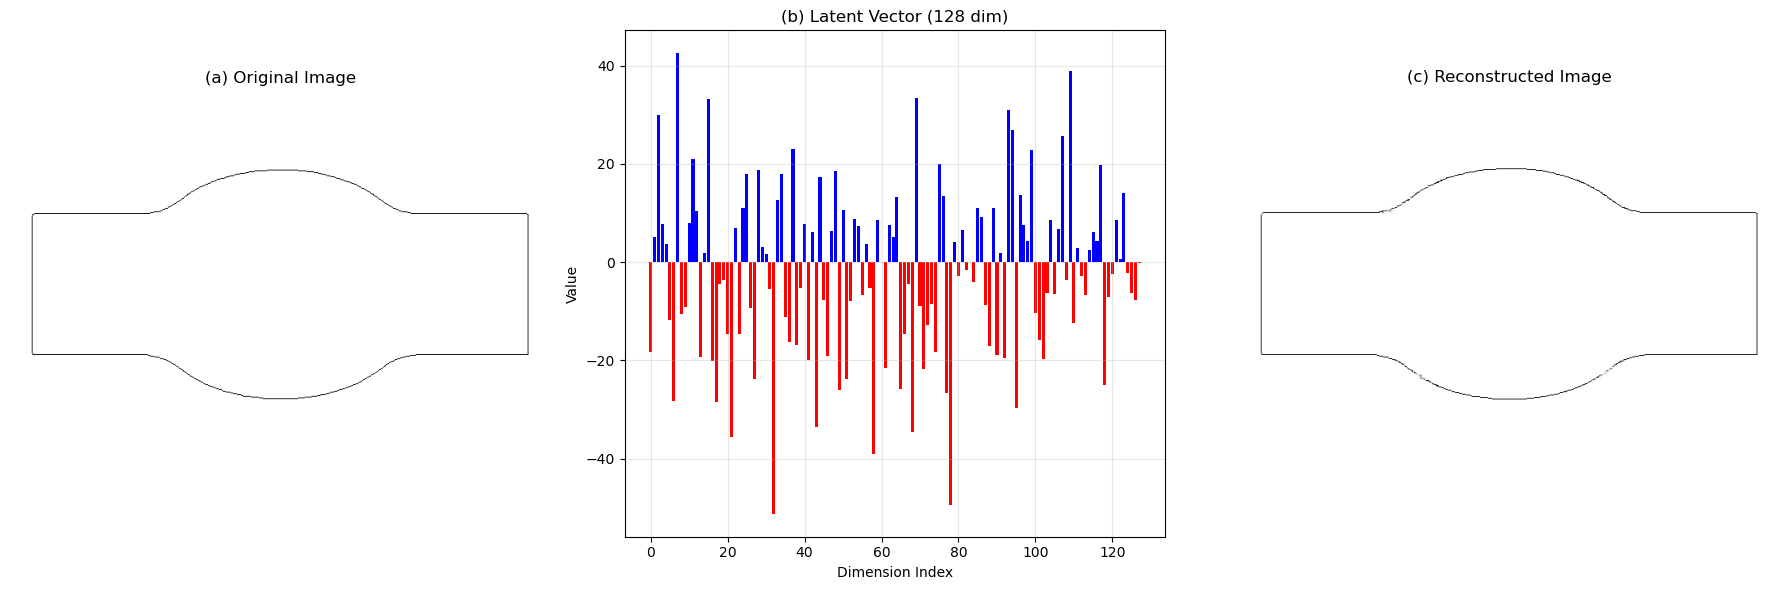


Analysis for image: idx_1_5_60.png
Latent vector shape: (128,)
Latent vector min/mean/max: -51.2170, -2.1865, 42.4934

Latent values:
[-1.83681e+01  5.19090e+00  2.99613e+01  7.84630e+00  3.70790e+00
 -1.18390e+01 -2.82886e+01  4.24934e+01 -1.06127e+01 -9.09620e+00
  7.88090e+00  2.09839e+01  1.03161e+01 -1.93360e+01  1.85220e+00
  3.31404e+01 -2.00649e+01 -2.85436e+01 -4.40220e+00 -3.69050e+00
 -1.45760e+01 -3.56011e+01  7.02370e+00 -1.45601e+01  1.09248e+01
  1.79181e+01 -9.39640e+00 -2.37304e+01  1.88307e+01  3.05350e+00
  1.57030e+00 -5.39180e+00 -5.12170e+01  1.27156e+01  1.78654e+01
 -1.11089e+01 -1.62979e+01  2.29461e+01 -1.68708e+01 -5.30580e+00
  7.65570e+00 -1.99834e+01  6.14900e+00 -3.35191e+01  1.72491e+01
 -7.68130e+00 -1.91976e+01  6.25070e+00  1.85762e+01 -2.60606e+01
  1.06223e+01 -2.37310e+01 -7.96550e+00  8.86860e+00  7.44560e+00
 -6.68830e+00  3.73260e+00 -5.17170e+00 -3.89926e+01  8.63120e+00
 -1.68000e-02 -2.15533e+01  7.59690e+00  5.14720e+00  1.32542e+01
 -2.585

In [201]:
model = CAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("models_cae/best_train_cae.pth"))
model.eval()

original_img, latent_vector, reconstructed_img = plot_reconstruction(model, 'dataset_thick', latent_dim=latent_dim, device=device)

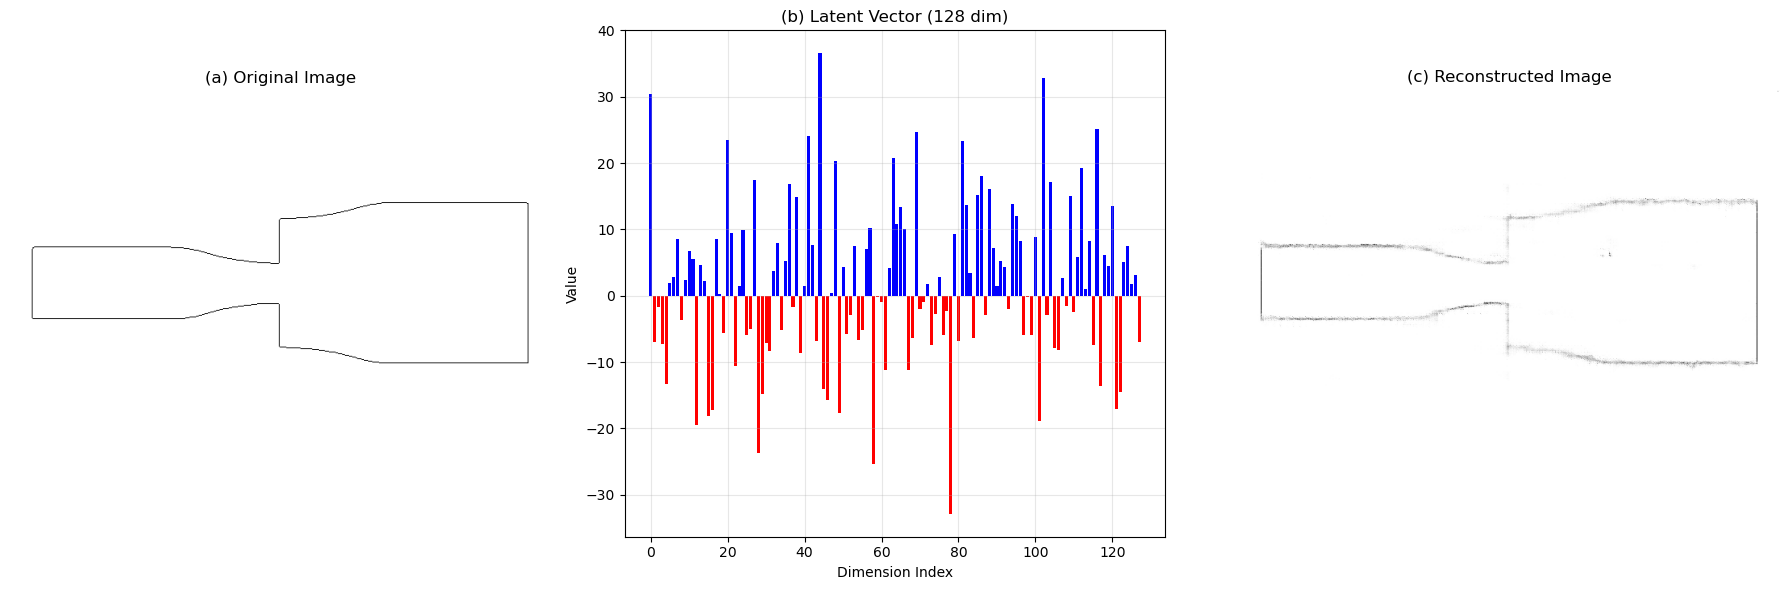


Analysis for image: idx_6_8_60.png
Latent vector shape: (128,)
Latent vector min/mean/max: -32.8653, 1.7317, 36.5530

Latent values:
[ 30.481   -7.0096  -1.7563  -7.2358 -13.3245   1.9919   2.8169   8.4953
  -3.6482   2.322    6.7592   5.5527 -19.4175   4.6744   2.1597 -18.1375
 -17.2078   8.5158   0.2882  -5.654   23.4954   9.4257 -10.5702   1.51
   9.9209  -5.9693  -4.9661  17.4    -23.6992 -14.7651  -7.1131  -8.2646
   3.7201   7.952   -5.0942   5.2299  16.7831  -1.6675  14.8419  -8.6295
   1.4259  24.0445   7.7088  -6.7766  36.553  -14.0403 -15.7912   0.3421
  20.3779 -17.6915   4.313   -5.84    -2.844    7.4639  -6.6703  -5.1389
   7.0871  10.2302 -25.3099  -0.226   -0.9571 -11.2431   4.2325  20.8195
  10.8099  13.4336  10.0108 -11.1583  -6.3861  24.7098  -1.9435  -0.8813
   1.7146  -7.4978  -2.7962   2.7813  -5.9653  -2.236  -32.8653   9.2844
  -6.8153  23.3059  13.6776   3.3857  -6.3232  15.1188  18.0837  -2.944
  16.0315   7.1654   1.4607   5.1895   4.2742  -1.9265  13.8194  1

In [202]:
model = CAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))
model.eval()

original_img, latent_vector, reconstructed_img = plot_reconstruction(model, 'dataset_thick', latent_dim=latent_dim, device=device)

In [7]:
def get_latent_vectors(model, dataset_path, device='cuda'):
    """Extracts latent vectors for all images in dataset."""
    model.eval()
    latent_vectors = []
    filenames = []
    
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    
    with torch.no_grad():
        for img_file in image_files:
            img_path = os.path.join(dataset_path, img_file)
            img = Image.open(img_path)
            img_array = np.array(img) / 255.0
            img_tensor = torch.FloatTensor(img_array).unsqueeze(0).unsqueeze(0).to(device)
            
            latent = model.encoder(img_tensor)
            latent_vectors.append(latent.cpu().numpy().squeeze())
            filenames.append(img_file)
    
    return np.array(latent_vectors), filenames

In [8]:
def parse_filename_pairs(filenames):
    """Extracts pair indices from filenames like 'idx_1_2_50.png'."""
    pairs = []
    for name in filenames:
        parts = name.split('_')
        idx1, idx2 = int(parts[1]), int(parts[2])
        pairs.append((idx1, idx2))
    
    # Assign unique cluster ID to each pair
    unique_pairs = list(set(pairs))
    pair_to_cluster = {pair: i for i, pair in enumerate(unique_pairs)}
    cluster_ids = [pair_to_cluster[pair] for pair in pairs]
    
    return cluster_ids, unique_pairs

In [9]:
from sklearn.manifold import TSNE

def reduce_dimensions(latent_vectors):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    return tsne.fit_transform(latent_vectors)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_clusters(tsne_results, cluster_ids, unique_pairs_count):
    plt.figure(figsize=(15, 10))
    palette = sns.color_palette("hsv", unique_pairs_count)
    
    scatter = plt.scatter(
        tsne_results[:, 0], 
        tsne_results[:, 1], 
        c=cluster_ids, 
        cmap='hsv', 
        alpha=0.7,
        s=10
    )
    
    plt.title('t-SNE Visualization of Latent Space Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()

In [17]:
from sklearn.manifold import TSNE

def reduce_dimensions(latent_vectors, n_samples):
    # Автоматическая настройка perplexity
    safe_perplexity = min(30, n_samples - 1)  # ограничение сверху
    tsne = TSNE(n_components=2, perplexity=safe_perplexity, random_state=42)
    return tsne.fit_transform(latent_vectors)

Уникальных пар: 78 (ожидалось 66)


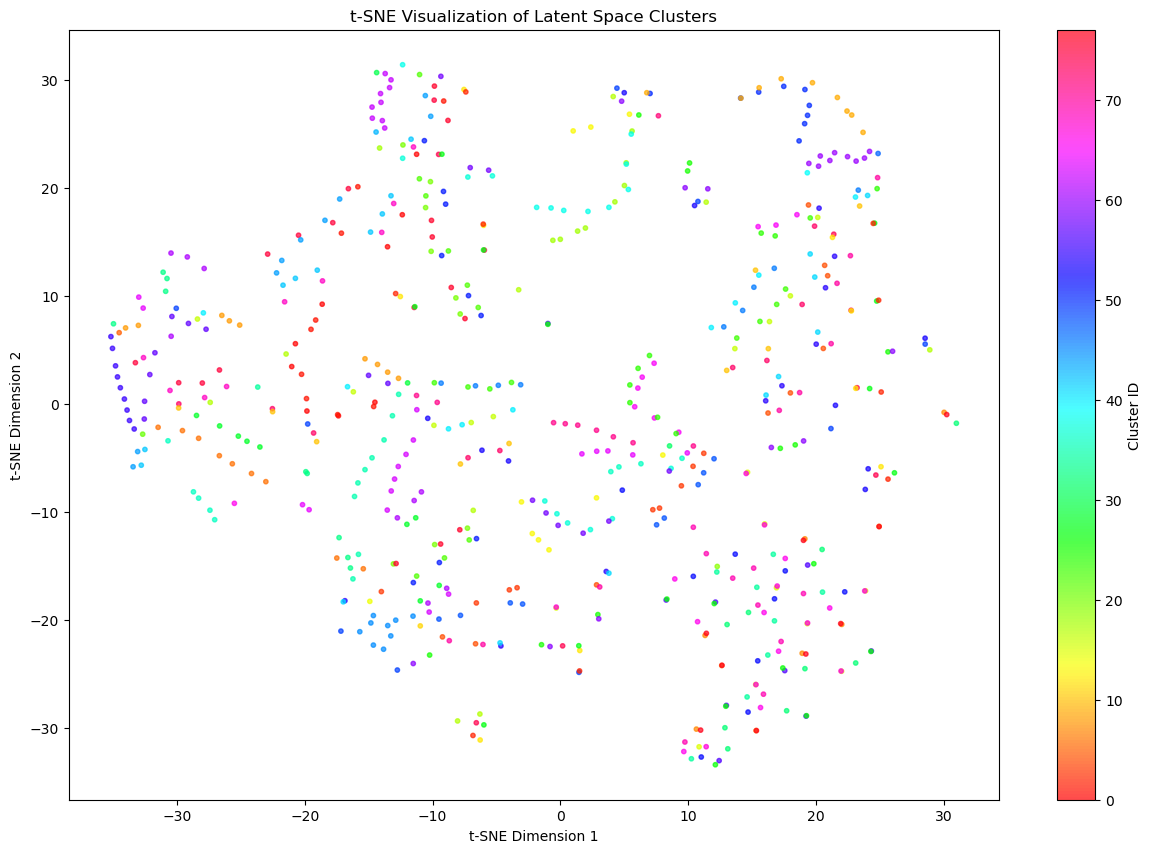

In [26]:
model = CAE(latent_dim=128).to(device)
model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))

# Извлечение данных
latent_vectors, filenames = get_latent_vectors(model, 'dataset_thick', device)

# Парсинг кластеров
cluster_ids, unique_pairs = parse_filename_pairs(filenames)
print(f"Уникальных пар: {len(unique_pairs)} (ожидалось 66)")

# Применение t-SNE
tsne_results = reduce_dimensions(latent_vectors, n_samples=606)

# Визуализация
plot_tsne_clusters(tsne_results, cluster_ids, len(unique_pairs))

Уникальных пар: 3


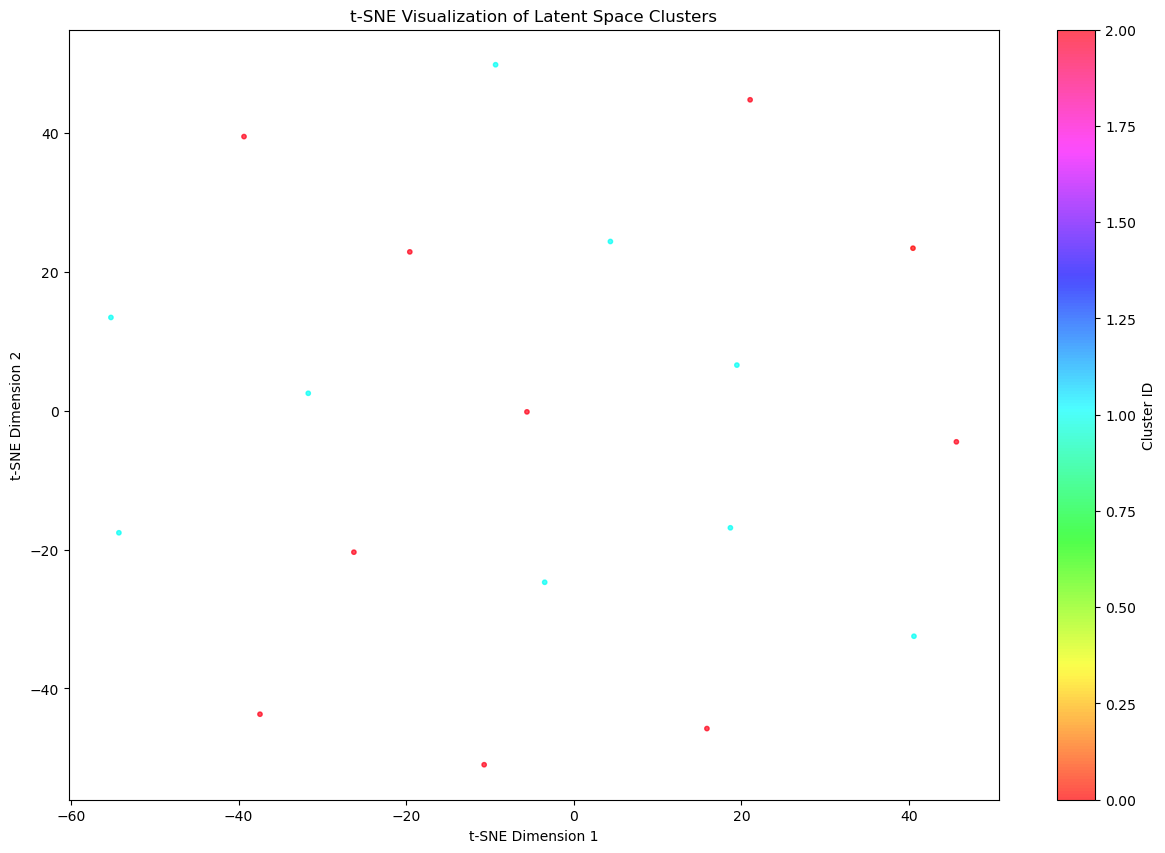

In [25]:
model = CAE(latent_dim=128).to(device)
model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))

# Извлечение данных
latent_vectors, filenames = get_latent_vectors(model, 'mini_dataset', device)

# Парсинг кластеров
cluster_ids, unique_pairs = parse_filename_pairs(filenames)
print(f"Уникальных пар: {len(unique_pairs)}")

# Применение t-SNE
tsne_results = reduce_dimensions(latent_vectors, n_samples=19)

# Визуализация
plot_tsne_clusters(tsne_results, cluster_ids, len(unique_pairs))

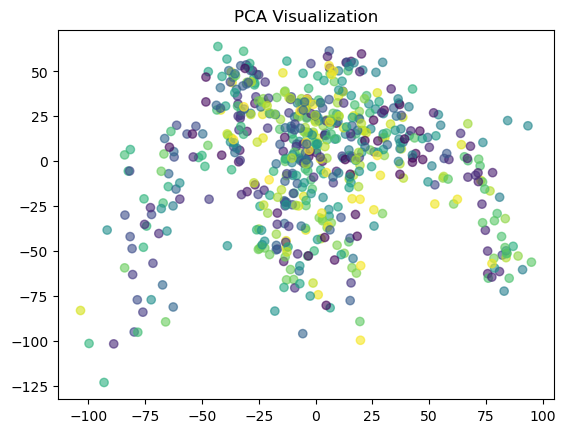

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_vectors)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_ids, cmap='viridis', alpha=0.6)
plt.title('PCA Visualization')
plt.show()

In [28]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent_vectors)

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_ids, cmap='viridis', alpha=0.6)
plt.title('UMAP Visualization')
plt.show()

ModuleNotFoundError: No module named 'umap'

c:\Users\2002d\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


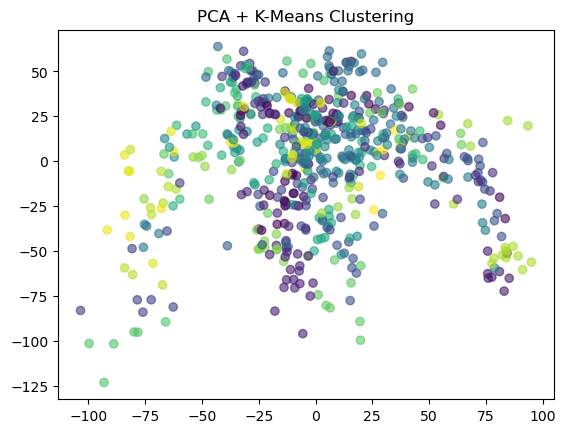

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=66)  # 66 кластеров по числу пар
clusters = kmeans.fit_predict(latent_vectors)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('PCA + K-Means Clustering')
plt.show()

c:\Users\2002d\anaconda3\envs\myenv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\2002d\anaconda3\envs\myenv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\2002d\anaconda3\envs\myenv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\2002d\anaconda3\envs\myenv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


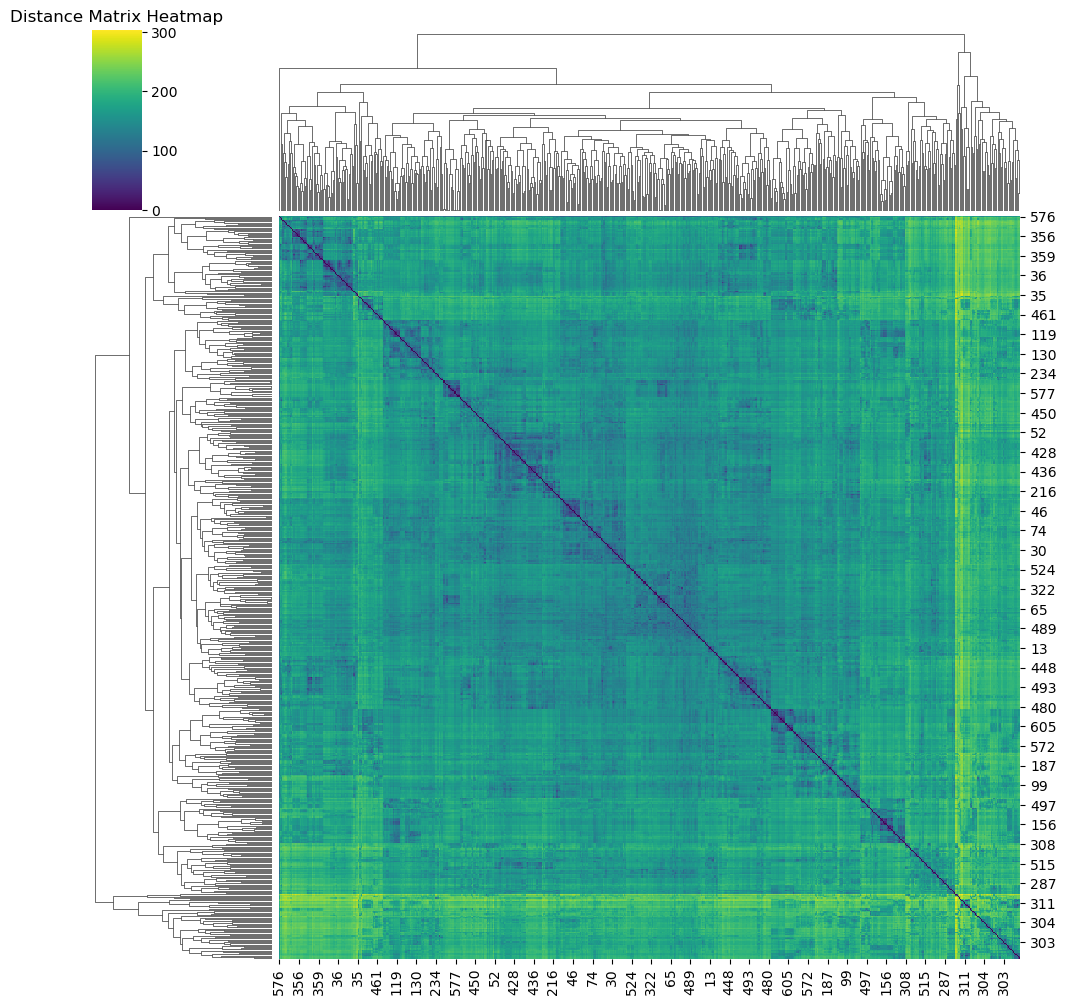

In [30]:
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances

distance_matrix = pairwise_distances(latent_vectors)
sns.clustermap(distance_matrix, cmap='viridis')
plt.title('Distance Matrix Heatmap')
plt.show()